# Boston Crime Incident Reports

https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system

# Purpose

1. Get an idea on where is the safer place to live in Boston

2. Practice the techniques of data science

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 
from fbprophet import Prophet
from sklearn import mixture
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

Importing plotly failed. Interactive plots will not work.


In [2]:
# Import CSV
df = pd.read_csv('./tmpjtmghb1v.csv')

# Set index
df.index = pd.to_datetime(df['OCCURRED_ON_DATE'])
# Sanitize the SHOOTING column
df['SHOOTING'] = df['SHOOTING'].apply(lambda x: 1 if x == 1 or x == 'Y' else 0)
# Remove unneccessary columsn
df.drop(columns=['INCIDENT_NUMBER', 'OFFENSE_CODE','OFFENSE_CODE_GROUP', 'REPORTING_AREA', 'OCCURRED_ON_DATE', 'UCR_PART', 'STREET', 'Location'], inplace=True)
# Drop unnecessary row
df.dropna(inplace=True)
df = df[(df['Lat']>40)&(df['Long']<-60)]

# Encode DISTRICT to numerical
le = {}
le['DISTRICT'] = preprocessing.LabelEncoder()
le['DISTRICT'].fit(df['DISTRICT'].unique())
df['DISTRICT'] = le['DISTRICT'].transform(df['DISTRICT'])
print("DISTRICT", le['DISTRICT'].classes_)

# Encode DAY_OF_WEEK to numerical
day_of_week = lambda x: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'].index(x)
df['DAY_OF_WEEK'] = df['DAY_OF_WEEK'].apply(day_of_week)


/Users/hiroakimachida/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (0,2,6,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


DISTRICT ['A1' 'A15' 'A7' 'B2' 'B3' 'C11' 'C6' 'D14' 'D4' 'E13' 'E18' 'E5'
 'External']


In [3]:
df.head()

,OFFENSE_DESCRIPTION,DISTRICT,SHOOTING,YEAR,MONTH,DAY_OF_WEEK,HOUR,Lat,Long
OCCURRED_ON_DATE,,,,,,,,,
2020-07-18 14:34:00,VERBAL DISPUTE,6,0,2020,7,5,14,42.330813,-71.051368
2020-06-24 10:15:00,THREATS TO DO BODILY HARM,10,0,2020,6,2,10,42.239491,-71.135954
2019-12-20 03:08:00,VERBAL DISPUTE,9,0,2019,12,4,3,42.325122,-71.107779
2019-10-23 00:00:00,INVESTIGATE PERSON,5,0,2019,10,2,0,42.297555,-71.059709
2019-11-22 07:50:00,WARRANT ARREST - OUTSIDE OF BOSTON WARRANT,7,0,2019,11,4,7,42.355120,-71.162678


# Provide appropriate plots and interpretations for the attributes of the dataset. Analysis should include the standalone attributes as well relationships amongst the attributes.

## Primary descriptor of incident

Unique values: 279


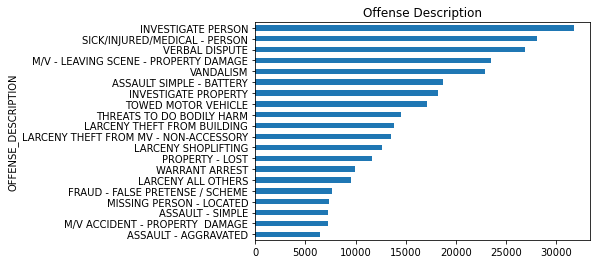

In [4]:
data = df.groupby('OFFENSE_DESCRIPTION').size()
data.sort_values()[-20:].plot.barh(title="Offense Description")
print("Unique values:", len(data))

The offense description has a long tail distribution considering there are 279 unique values.

## District the crime was reported in

For district map see https://bpdnews.com/districts or https://www.researchgate.net/figure/Boston-Police-Department-districts-included-in-BWC-evaluation_fig1_336674159

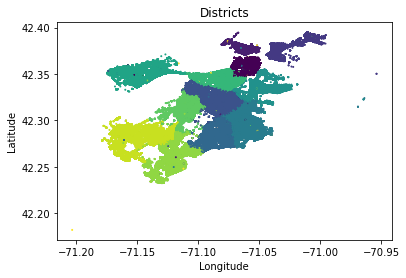

In [5]:
plt.title('Districts')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(df['Long'], df['Lat'], cmap='viridis',c=df['DISTRICT'], s=1)

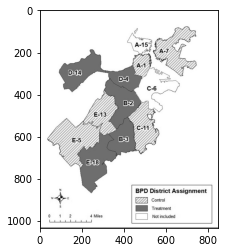

In [6]:
img = mpimg.imread('./district.png')
imgplot = plt.imshow(img)

<AxesSubplot:title={'center':'Number of reports per district'}>

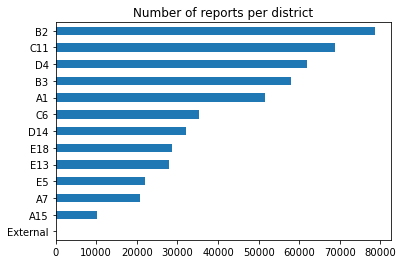

In [7]:
data = df.groupby('DISTRICT').size().sort_values()
data.index = le['DISTRICT'].inverse_transform(data.index)
data.plot.barh(title='Number of reports per district')

B2 (Roxbury) has 8 times more incidents reported than A15 (Charlestown).

## Shooting took place

Number of shooting: 25785
% of shooting: 0.005778108531634388


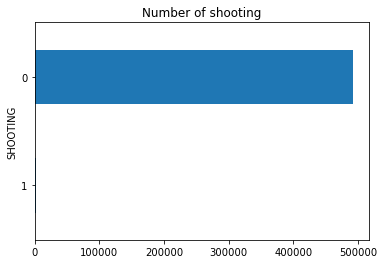

In [8]:
df.groupby('SHOOTING').size().sort_values().plot.barh(title="Number of shooting")
print("Number of shooting:", df[df['SHOOTING']==True].size)
print("% of shooting:", df[df['SHOOTING']==True].size/df.size)

0.5% of reports involves shooting.

## Earliest date and time the incident could have taken place

<AxesSubplot:title={'center':'Number of reports per year and month'}, xlabel='YEAR,MONTH'>

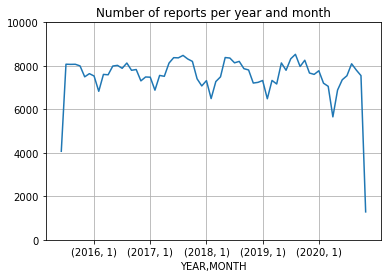

In [9]:
data = df.groupby(['YEAR','MONTH']).size()
data.plot(title='Number of reports per year and month',ylim=(0,10000),xticks=range(len(data))[7::12],grid=True)

The number of crimes increases in summer.

<AxesSubplot:title={'center':'Number of reports per day of week and hour'}, xlabel='DAY_OF_WEEK,HOUR'>

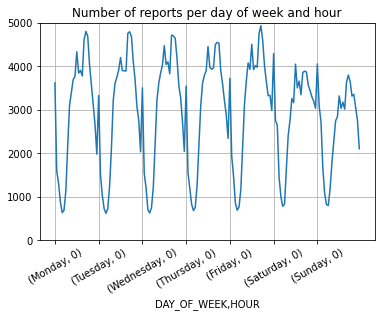

In [10]:
data = df.groupby(['DAY_OF_WEEK','HOUR']).size()
day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data.index = data.index.set_levels(day_of_week, level=0)
data.plot(title='Number of reports per day of week and hour',ylim=(0,5000),xticks=range(len(data))[::24],grid=True,rot=30)

The number of crimes increases in daytime.

## Latitude and longitude

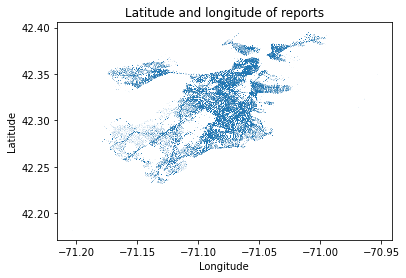

In [11]:
plt.title('Latitude and longitude of reports')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(df['Long'], df['Lat'],cmap='viridis',s=0.0001)

The numbers of crimes are higher in the east part.

# Do the time series analysis and forecasting predictions of the dataset. Provide the appropriate plots and interpretations.

In [12]:
df_daily = df.groupby(level=0).size().resample('D').asfreq()
data = pd.DataFrame({'ds': df_daily.index.values, 'y': df_daily.values})

In [13]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m.fit(data)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

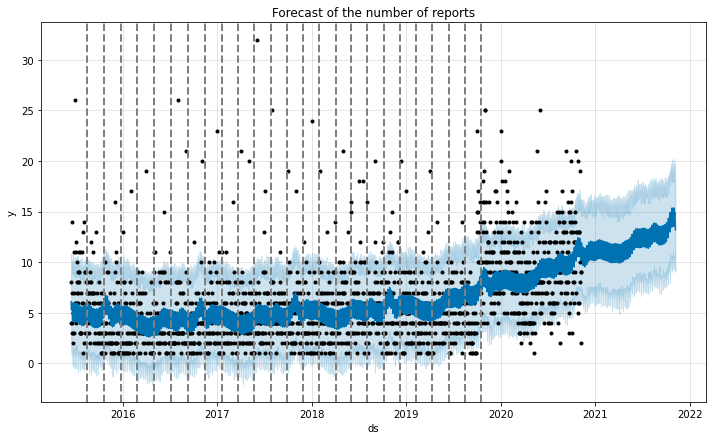

In [14]:
fig1 = m.plot(forecast)
plt.title('Forecast of the number of reports')
for cp in m.changepoints:
    plt.axvline(cp, c='gray', ls='--', lw=2)

Prophet predicts the number of crime reports will increase in the future.

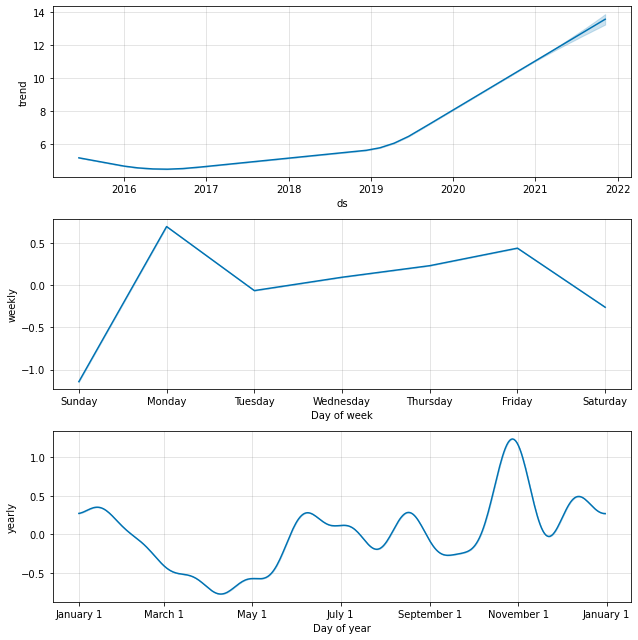

In [15]:
fig2 = m.plot_components(forecast)

The number of crimes is small on weekends. It increases in November.

# Do linear and logistic regression analysis on the data. Provide the appropriate plots and interpretations.

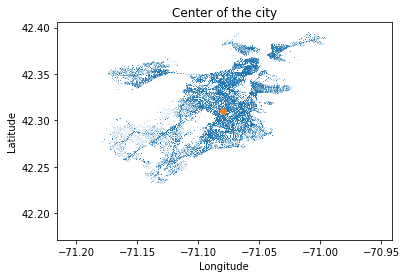

In [16]:
plt.title('Center of the city')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(df['Long'], df['Lat'], s=0.0001)
plt.scatter([-71.08], [42.31], s=30)

Calculated the distances to the center of Boston from the locations where incidents reported.

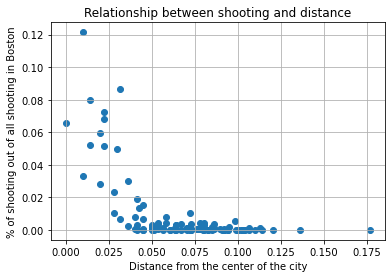

In [17]:
distance = (((df['Lat'].round(decimals=2)-42.31)**2+(df['Long'].round(decimals=2)-(-71.08))**2))**0.5
rate = df['SHOOTING']/df['SHOOTING'].sum()
data = pd.DataFrame({'Distance':distance, 'Rate':rate}).groupby('Distance').sum()
plt.title('Relationship between shooting and distance')
plt.xlabel('Distance from the center of the city')
plt.ylabel('% of shooting out of all shooting in Boston')
plt.grid()
plt.xlim=(min(distance), max(distance))
plt.scatter(data.index.values, data['Rate'])

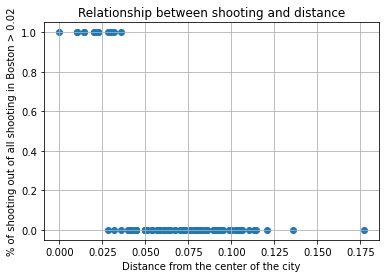

In [18]:
data['Rate'] = data['Rate'].apply(lambda x: 1 if x > 0.02 else 0)
plt.scatter(data.index.values, data['Rate'])
plt.title('Relationship between shooting and distance')
plt.xlabel('Distance from the center of the city')
plt.ylabel('% of shooting out of all shooting in Boston > 0.02')
plt.grid()

In [19]:
# Reverse the signs to apply logistic regression
X = np.array(-data.index.values)[:, np.newaxis]
y = np.array(data['Rate'])

In [20]:
ols = LinearRegression()
ols.fit(X, y)

LinearRegression()

In [21]:
clf = LogisticRegression(C=1e10)

clf.fit(X, y)

LogisticRegression(C=10000000000.0)

In [22]:
def model(x):
    return 1 / (1 + np.exp(-x))

In [23]:
X_test = np.linspace(-0.12, 0, 100)
loss = model(X_test * clf.coef_ + clf.intercept_)

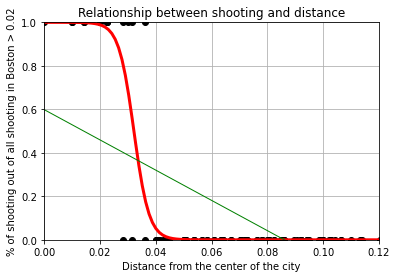

In [24]:
plt.title('Relationship between shooting and distance')
plt.xlabel('Distance from the center of the city')
plt.ylabel('% of shooting out of all shooting in Boston > 0.02')

# Reverse the signs back
plt.plot(-X, y, 'ko')
plt.axis([0, 0.12, 0, 1])
plt.grid(True)
plt.plot(-X_test, loss.flatten(), color='r', linewidth=3)
plt.plot(-X_test, ols.coef_ * X_test + ols.intercept_, linewidth=1, color='g')

Both Linear and Logistic suggests shooting rate decreases as getting further from the center of city.

# Using Principal Component Analysis, determine which attributes are important for the analysis. (Do one analysis of SelectKBest features for important attributes and another using PCA for important components)

In [25]:
# Prepare data
X = df[['YEAR','MONTH','DAY_OF_WEEK','HOUR']].copy()
y = df['SHOOTING'].copy()
X['DISTANCE'] = (((df['Lat']-42.31)**2+(df['Long']-(-71.08))**2))**0.5

## SelectKBest

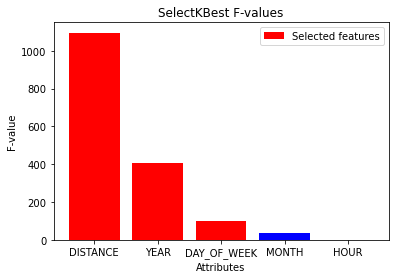

In [26]:
# Select K best
k = 3
selector = SelectKBest(f_regression, k=k)
selector.fit(X, y)

features = X.columns[selector.get_support()]

scores = np.array(sorted(list(zip(X.columns, selector.scores_, selector.pvalues_)), key = lambda x: x[1], reverse=True))
colors = ['r'] * k + ['b'] * (len(X.columns)-k)

# Scores and p values
plt.title('SelectKBest F-values')
plt.xlabel('Attributes')
plt.ylabel('F-value')
plt.bar(scores[:,0], scores[:,1].astype(float), color=colors, label='Selected features')
plt.legend()

The most important attributes SelectKBest chose are the distance, year, and day of week to predict the shooting rate.

In [27]:
X_KBest = X.iloc[:, selector.get_support()]

def plot_scatter(X,Y,R=None):
    plt.title("Relationship between shooting and distance: " + X.name)
    plt.ylabel('% of shooting out of all shooting in Boston > 0.02?')
    plt.xlabel(X.name)
    plt.grid()
    plt.scatter(X, Y, s=32, marker='o', facecolors='none', edgecolors='k')
    if R is not None:
        plt.scatter(X, R, color='red', linewidth=0.5)
    plt.show()    

regressor = LinearRegression(normalize=True).fit(X, y)
y_pred = regressor.predict(X)

print("The max probability that shooting happens:")
print(max(y_pred))
print("When:")
print(X_KBest.iloc[np.argmax(y_pred)])
print()
print("R-squared score: {:.4f}".format(r2_score(y, y_pred)))
print("Mean squared error: {:.4f}".format(mean_squared_error(y, y_pred)))

The max probability that shooting happens:
0.01851870368468722
When:
YEAR           2020.000000
DAY_OF_WEEK       6.000000
DISTANCE          0.000902
Name: 2020-11-01 20:49:00, dtype: float64

R-squared score: 0.0035
Mean squared error: 0.0057


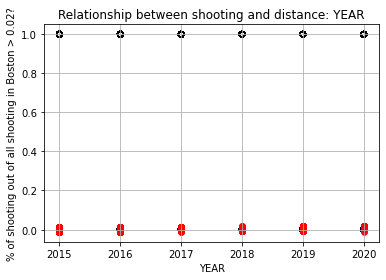

In [28]:
plot_scatter(X_KBest.iloc[:,0], y, y_pred)

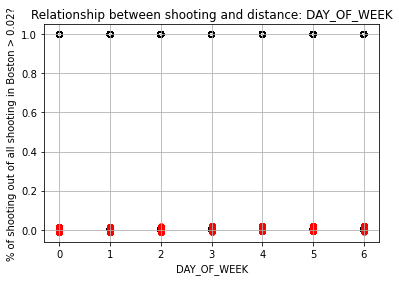

In [29]:
plot_scatter(X_KBest.iloc[:,1], y, y_pred)

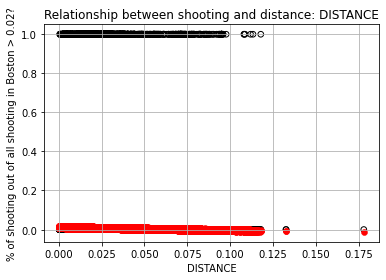

In [30]:
plot_scatter(X_KBest.iloc[:,2], y, y_pred)

The most important attributes are the distance, year, and day of week. The model predicts the probability is the hightest when distance is 0.000902, year 2020, and day of week Sunday. That suggests you may want to stay at home when you live closer to the center of the city, year goes on, and it's Sunday.

## Principal Component Analysis

In [31]:
# Prepare and fit model
ss = StandardScaler()
pca = PCA()
pipeline = make_pipeline(ss, pca)
feature = pipeline.fit(X).transform(X)

In [32]:
# Principal component score
pd.DataFrame(feature, columns=["PC{}".format(x + 1) for x in range(len(X.columns))]).head()

,PC1,PC2,PC3,PC4,PC5
0,0.997755,0.527867,-0.567307,0.761621,-1.114501
1,1.243679,0.823591,2.176657,-0.111638,-0.848233
2,-0.467328,1.394135,-0.624949,-0.886026,-1.698188
3,-0.029415,0.929469,-0.554461,-1.961665,-1.291044
4,-0.255610,1.910470,1.894606,0.223972,-1.424868


Text(0, 0.5, 'PC2')

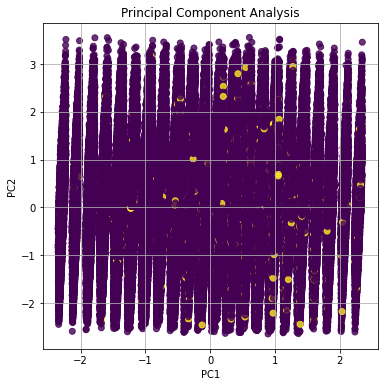

In [33]:
# Plot PC1 and PC2
plt.figure(figsize=(6, 6))
plt.scatter(feature[:, 0], feature[:, 1], alpha=0.8, c=list(y))
plt.grid()
plt.title("Principal Component Analysis")
plt.xlabel("PC1")
plt.ylabel("PC2")

In [34]:
# Contribution rate
pd.DataFrame(pca.explained_variance_ratio_, index=["PC{}".format(x + 1) for x in range(len(X.columns))])

,0
PC1,0.237896
PC2,0.208046
PC3,0.199325
PC4,0.192692
PC5,0.162041


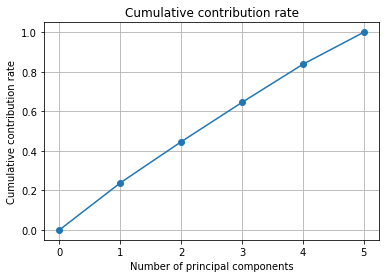

In [35]:
# Cumulative contribution rate
import matplotlib.ticker as ticker
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.plot([0] + list( np.cumsum(pca.explained_variance_ratio_)), "-o")
plt.title("Cumulative contribution rate")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative contribution rate")
plt.grid()

In [36]:
# Eigenvalue
pd.DataFrame(pca.explained_variance_, index=["PC{}".format(x + 1) for x in range(len(X.columns))])

,0
PC1,1.189482
PC2,1.040233
PC3,0.996626
PC4,0.963463
PC5,0.810206


In [37]:
# Eigenvector
pd.DataFrame(pca.components_, columns=X.columns[:], index=["PC{}".format(x + 1) for x in range(len(X.columns))])

,YEAR,MONTH,DAY_OF_WEEK,HOUR,DISTANCE
PC1,0.707207,-0.706503,-0.002228,-0.025993,0.005653
PC2,0.016735,0.042869,0.633365,-0.687598,0.352051
PC3,0.007752,0.013421,-0.418490,0.078735,0.904669
PC4,0.013726,-0.012925,0.650597,0.720820,0.238299
PC5,-0.706633,-0.706165,0.020817,-0.027433,0.028548


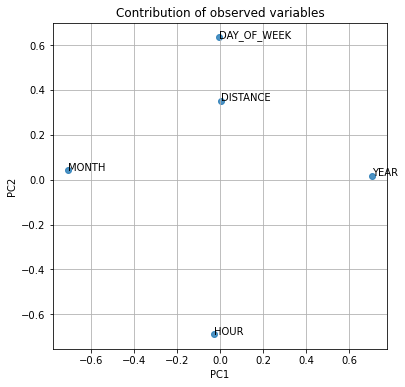

In [38]:
# Contribution of observed variables
plt.figure(figsize=(6, 6))
for x, y, name in zip(pca.components_[0], pca.components_[1], X.columns[:]):
    plt.text(x, y, name)
plt.scatter(pca.components_[0], pca.components_[1], alpha=0.8)
plt.grid()
plt.title("Contribution of observed variables")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Year is the most important for the analysis, because it has the highest contribution on the PC 1 eigenvector. Month has the 2nd highest contribution on PC1.
On PC2, Day of Week and Hour have the highest contributions.

# Perform classification analysis using Naïve Bayes, Decision trees, and Support Vector machine algorithms. Provide the appropriate plots and interpretations.

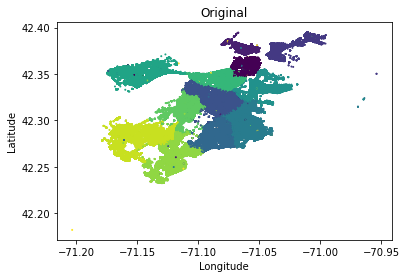

In [39]:
plt.title('Original')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(df['Long'], df['Lat'], cmap='viridis',c=df['DISTRICT'], s=1)

In [40]:
used_features =["Lat","Long",]

In [41]:
rng = np.random.RandomState(123)
Xnew = [42.20, -71.20] + [42.40-42.20, -70.95-(-71.20)] * rng.rand(10000, 2)

## Naïve Bayes

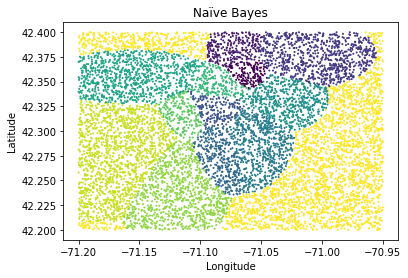

In [42]:
# Naïve Bayes
model = GaussianNB()
model.fit(df[["Lat","Long"]], df['DISTRICT'])
Ynew = model.predict(Xnew)

plt.title('Naïve Bayes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(Xnew[:,1], Xnew[:,0], cmap='viridis', c=Ynew, s=1)

The districts are classified very well. Even the "external" district (yellow) is classified almost perfectly. (It seems there's no external district on the original map, but it's just the number is too small.)
It should be no problem that Somerville (north part of Boston) and Newton (west) are not classified well as external district, because there are almost no data in the map.

## Decision trees

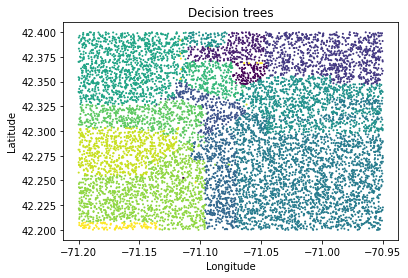

In [43]:
# Deicision Trees
model = DecisionTreeClassifier()
model.fit(df[["Lat","Long"]], df['DISTRICT'])
Ynew = model.predict(Xnew)

plt.title('Decision trees')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(Xnew[:,1], Xnew[:,0], cmap='viridis', c=Ynew, s=1)

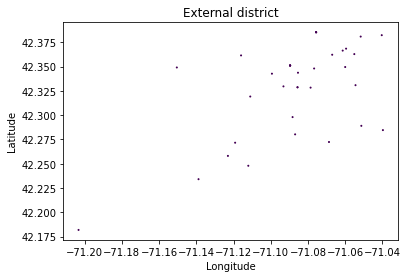

In [44]:
# External district
external = df[df['DISTRICT']==12]

plt.title('External district')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(external['Long'], external['Lat'], cmap='viridis',c=external['DISTRICT'], s=1)

It is not classified as well as Naïve Bayes. The bottom right part is not classified as external district. The area classified looks straight, compared to Naïve Bayes.

## Support Vector Machine

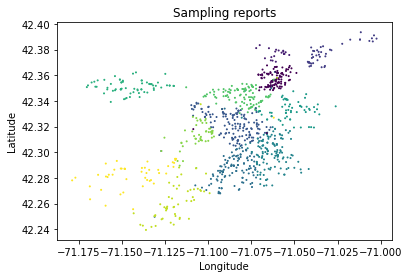

In [45]:
df_svm = df.sample(1000)

plt.title('Sampling reports')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(df_svm['Long'], df_svm['Lat'], cmap='viridis', c=df_svm['DISTRICT'], s=1)

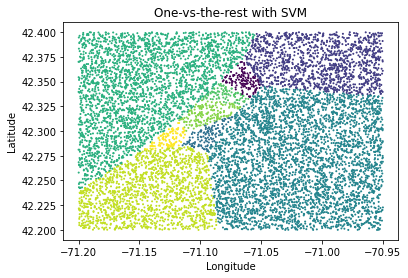

In [46]:
# Support Vector Machine
model = OneVsRestClassifier(SVC(kernel='linear'))
model.fit(df_svm[["Lat","Long"]], df_svm['DISTRICT'])
Ynew = model.predict(Xnew)

plt.title('One-vs-the-rest with SVM')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(Xnew[:,1], Xnew[:,0], cmap='viridis', c=Ynew, s=1)

Even slightly worse than Desicion Tree. The bottom center part is classified as one district, that is even Desicion Tree classified as multiple class. The top left part is also the same.
In addition, it is needed to sample from the original data because the fit function is too slow, and OneVsRestClassifier is used because SVC did not classify it well even if it's four classes.

In conclusion, Naïve Bayes represents the original map best, followed by Decision Trees and SVM.

# Do the clustering techniques on the dataset. Provide the appropriate plots and interpretations. Note: Use any two clustering methods.

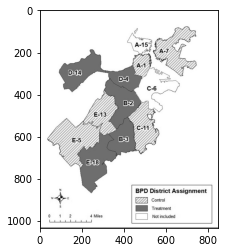

In [47]:
img = mpimg.imread('./district.png')
imgplot = plt.imshow(img)

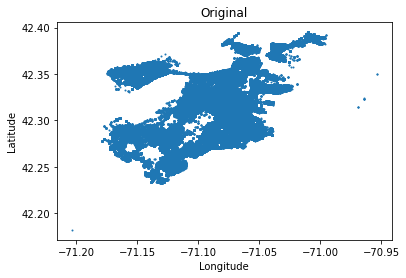

In [48]:
plt.title('Original')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(df['Long'], df['Lat'], s=1)

## K-means

In [49]:
kmeans = KMeans(n_clusters=12, random_state=0)
kmeans.fit(df[["Lat","Long"]])

KMeans(n_clusters=12, random_state=0)

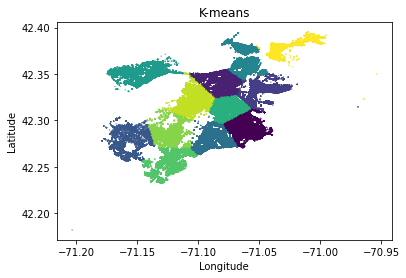

In [50]:
plt.title('K-means')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(df['Long'], df['Lat'], cmap='viridis',c=kmeans.labels_, s=0.1)

Boston can be divided into districts more evenly by K-means than real world, in terms of area. As shown in the picture above, E-5 looks 3-4 times larger than A-15. In K-means, it is divided more evenly.

## Spectral Clustering

/Users/hiroakimachida/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


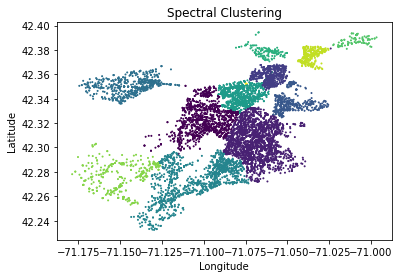

In [51]:
sample = df[["Lat","Long"]].sample(10000)

model_s = SpectralClustering(n_clusters=12, affinity='nearest_neighbors', assign_labels='kmeans')
labels_s = model_s.fit(sample)
plt.title('Spectral Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(sample["Long"], sample["Lat"], c=model_s.labels_, cmap='viridis', s=1)

Unevenly classified. Only 11 areas can be seen, although there are 12. There might be several predicted classes with only a few dots.

## Gaussian Mixture Models

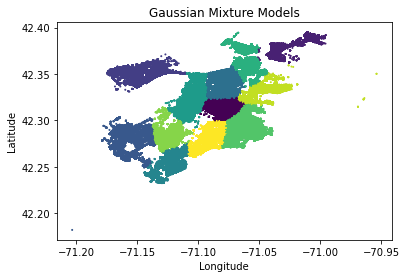

In [52]:
gmm = mixture.GaussianMixture(n_components=12)
labels = gmm.fit(df[["Lat","Long"]]).predict(df[["Lat","Long"]])
plt.title('Gaussian Mixture Models')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(df["Long"], df["Lat"], c=labels, cmap='viridis', s=1)

Slightly worse than the K-means. Certain areas are bigger than others, probably due to the initial state.

In conclusion, K-means divides the are the most evenly, followed by GMM, and Spectral Clustering.

# Conclusion

1. Get an idea on where is the safer place to live in Boston<br/>=> The further from the center of the city, the safer.


2. Practice the techniques of data science<br/>=> We learned Time Series Analysis, Regression Analysis, Feature Selection, Classification Analysis, and Clustering Techniques.